# Setup

In [2]:
import sys
sys.path.append('/mnt/c/Users/Arnisa/Desktop/MP/mp-tl-study')
from functions.visualization_utils import *

## Load Data

In [3]:
# load baselines: filename!!
with open('results/cifarstyle_baselines_freeze_True_pool_True.json', 'r') as f:
    baselines = json.load(f)
baselines = baselines[1:]

# load results; filename
with open('results/cifarstyle_results_freeze_True_reinit_True_pool_True.json', 'r') as f:
    results = json.load(f)

# Run this if the first element of the results is the PARAMS dict
params = results[0]
results = results[1:]
# if not, initialize a params dict -see 3. Init params

data_dicts = baselines + results 
# Create DataFrame from the list of dictionaries
df = pd.DataFrame(data_dicts)

# Rename the columns to match the specified names
df.rename(columns={
    'lr': 'learning rate',
    'sampled_percentage': 'Percentage',
    'sampled_cut_point': 'Cut Point',
    'repeat': 'Trial',
    'train_acc': 'Train Accuracy',
    'test_acc': 'Test Accuracy'
}, inplace=True)

# Display the DataFrame (showing the first few rows for brevity)
df.head()

,learning rate,Percentage,Cut Point,Trial,Train Accuracy,Test Accuracy
0,0.001,0.001,-1,0,1.00,0.717623
1,0.001,0.001,-1,1,1.00,0.705346
2,0.001,0.001,-1,2,0.92,0.762175
3,0.001,0.001,-1,3,1.00,0.712964
4,0.001,0.001,-1,4,1.00,0.708917


In [3]:
# Filter the baselines to these percentages: 0.001, 0.01, 0.1, 0.5, 1.0
# because there are some extra percentages
baselines = [result for result in baselines if result["sampled_percentage"] in [0.001, 0.01, 0.1, 0.5, 1.0]]

results = [result for result in results if result["sampled_percentage"] in [0.001, 0.01, 0.1, 0.5, 1.0]]
data_dicts = baselines + results 
# Create DataFrame from the list of dictionaries
df = pd.DataFrame(data_dicts)

# Rename the columns to match the specified names
df.rename(columns={
    'lr': 'learning rate',
    'sampled_percentage': 'Percentage',
    'sampled_cut_point': 'Cut Point',
    'repeat': 'Trial',
    'train_acc': 'Train Accuracy',
    'test_acc': 'Test Accuracy'
}, inplace=True)

# Display the DataFrame (showing the first few rows for brevity)
df.head()

,learning rate,Percentage,Cut Point,Trial,Train Accuracy,Test Accuracy
0,0.001,0.001,-1,0,1.00,0.717623
1,0.001,0.001,-1,1,1.00,0.705346
2,0.001,0.001,-1,2,0.92,0.762175
3,0.001,0.001,-1,3,1.00,0.712964
4,0.001,0.001,-1,4,1.00,0.708917


In [4]:
df_empirical = df.copy()

In [33]:
# OR LOAD ARI Scores
"""with open("results_jsons/ari/ari_scores_finetuned_Fashion_to_MNIST.json", "r") as f:
    ari_scores_all = json.load(f)
df_ari = pd.DataFrame(ari_scores_all)

# Display the DataFrame (showing the first few rows for brevity)
df_ari.head()"""

# 1. The plots
See the documentation (mp-tl-study/example_visualizations.ipynb) for a full list of supported visualizations

### Experimental Plots

In [55]:
def box_plot(params:dict, df:pd.DataFrame, 
                rank_df:pd.DataFrame, unique_ranks:list=None, color_palette:str="viridis", 
                pairwise_rank_df:pd.DataFrame=None, pairwise:bool=False, 
                ylim:float=None, yscale:str=None, figsize:tuple=None, 
                add_baseline:bool=False, tick_labels_dict:dict=None):
    # Creating subplots for each data percentage
    unique_percentages = df['Percentage'].unique()
    n_percentages = len(unique_percentages)

    if unique_ranks is None:
        unique_ranks = rank_df['rank'].unique()
    ranks_lim = unique_ranks.max()
    rank_color_map = {rank: ranks_lim+1-rank for rank in range(ranks_lim, 0, -1)}
    # print(rank_color_map)

    if figsize is None:
        figsize = (10, 3 * n_percentages)

    # Adjusting the subplot layout for better readability of median values
    fig, axes = plt.subplots(nrows=n_percentages, ncols=1, figsize=figsize, sharex=True)

    for i, percentage in enumerate(sorted(unique_percentages)):
        ax = axes[i]
        
        # Filtering data for each percentage
        df_subset = df[df['Percentage'] == percentage]

        # Custom coloring based on ranks sorted by median accuracy
        rank_subset = rank_df[rank_df['Percentage'] == percentage]
        ranks = rank_subset.set_index('Cut Point')['rank']
        if add_baseline:
            ranks.loc[-1] = ranks.loc[0]   
        ranks_sorted = ranks.sort_values(ascending=False)
        rank_txt_map = {rank:rank_id+1 for rank_id,rank in enumerate(sorted(list(np.unique(ranks))))}
        
        cut_color_map = {cut: rank_color_map[rank] for cut, rank in ranks_sorted.items()}
        cut_rank_map = {cut: rank for cut, rank in ranks_sorted.items()}
        color_palette = sns.color_palette(color_palette, len(rank_color_map)+1)
        palette = {cut: color_palette[color_id] for cut, color_id in cut_color_map.items()}

        ax = sns.boxplot(x='Cut Point', y='Test Accuracy', data=df_subset, ax=axes[i], palette=palette)
        
        if pairwise:
            # Custom coloring based on ranks sorted by median accuracy
            pairwise_rank_subset = pairwise_rank_df[pairwise_rank_df['Percentage'] == percentage]
            pairwise_ranks = pairwise_rank_subset.set_index('Cut Point')['rank']
            if add_baseline:
                pairwise_ranks.loc[-1] = pairwise_ranks.loc[0]   
            pairwise_ranks_sorted = pairwise_ranks.sort_values(ascending=False)

            rank_hatch_map = {1:"//", 5:None, 8:"*"}
            cut_hatch_map = {cut: rank_hatch_map[rank] for cut, rank in pairwise_ranks_sorted.items()}
            cuts = sorted(list(cut_hatch_map.keys()))
        
        # Apply hatching patterns
        if pairwise:
            for j, box in enumerate(ax.artists):
                cut = cuts[j]
                hatch = cut_hatch_map.get(cut, '')
                box.set_hatch(hatch)
                # box.set_edgecolor('white')

        cuts = sorted(list(cut_rank_map.keys()))
        # print(cuts)
        medians = df_subset.groupby(['Cut Point'])['Test Accuracy'].median().sort_index()
        for j, median in enumerate(medians):
            baseline_error_rate = 1 - medians.loc[0]
            median_error_rate = 1 - median
            rer =  (baseline_error_rate - median_error_rate) / baseline_error_rate * 100
            txt = f'ACC: {median:.3f}\nRER: {rer:.3f}\nRank: {rank_txt_map[cut_rank_map[j+min(cuts)]]}'
            text = axes[i].text(j, median-0.1, txt, horizontalalignment='center', size='small', color='white', weight='semibold')
            text.set_path_effects([patheffects.withStroke(linewidth=1.5, foreground="black")])

        axes[i].set_title(f'Sampled Percentage: {percentage*100}%')
        axes[i].set_xlabel('Layer')
        if ylim:
            axes[i].set_ylim(ylim, 1.0)
        if yscale:
            axes[i].set_yscale('log')

        if i == n_percentages - 1:
            if tick_labels_dict:
                axes[i].set_xlabel('Feature Extractor Layer')
            else:
                axes[i].set_xlabel('Cut Point')
        else:
            axes[i].set_xlabel('')
        if tick_labels_dict:
            axes[i].set_ylabel('PPR Score')

    if tick_labels_dict:
        final_ax = axes[-1]
        current_ticks = final_ax.get_xticks()
        final_ax.set_xticks(current_ticks)
        final_ax.set_xticklabels([tick_labels_dict.get(int(tick+min(cuts)), tick+min(cuts)) for tick in current_ticks])

    # Adding legend
    if pairwise:
        handles = [mpatches.Patch(fill=False, hatch="***", label='Significantly Higher'), 
                   mpatches.Patch(fill=False, hatch=None, label='Not Significant'), 
                   mpatches.Patch(fill=False, hatch="///", label='Significantly Lower')]
        fig.legend(handles=handles, loc='upper right')

    # Adding a super title -just print it out for the latex
    print(f'Freeze = {params["freeze"]}, Reinitialize = {params["reinit"]}, Pooling = {params["use_pooling"]}, Learning rate = {params["lr_fine_tune"]}')
    fig.subplots_adjust(top=0.85)
    plt.tight_layout()

    return plt

/home/arnisa/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


Freeze = True, Reinitialize = True, Pooling = True, Learning rate = 0.001


/tmp/ipykernel_16669/3230850846.py:107: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


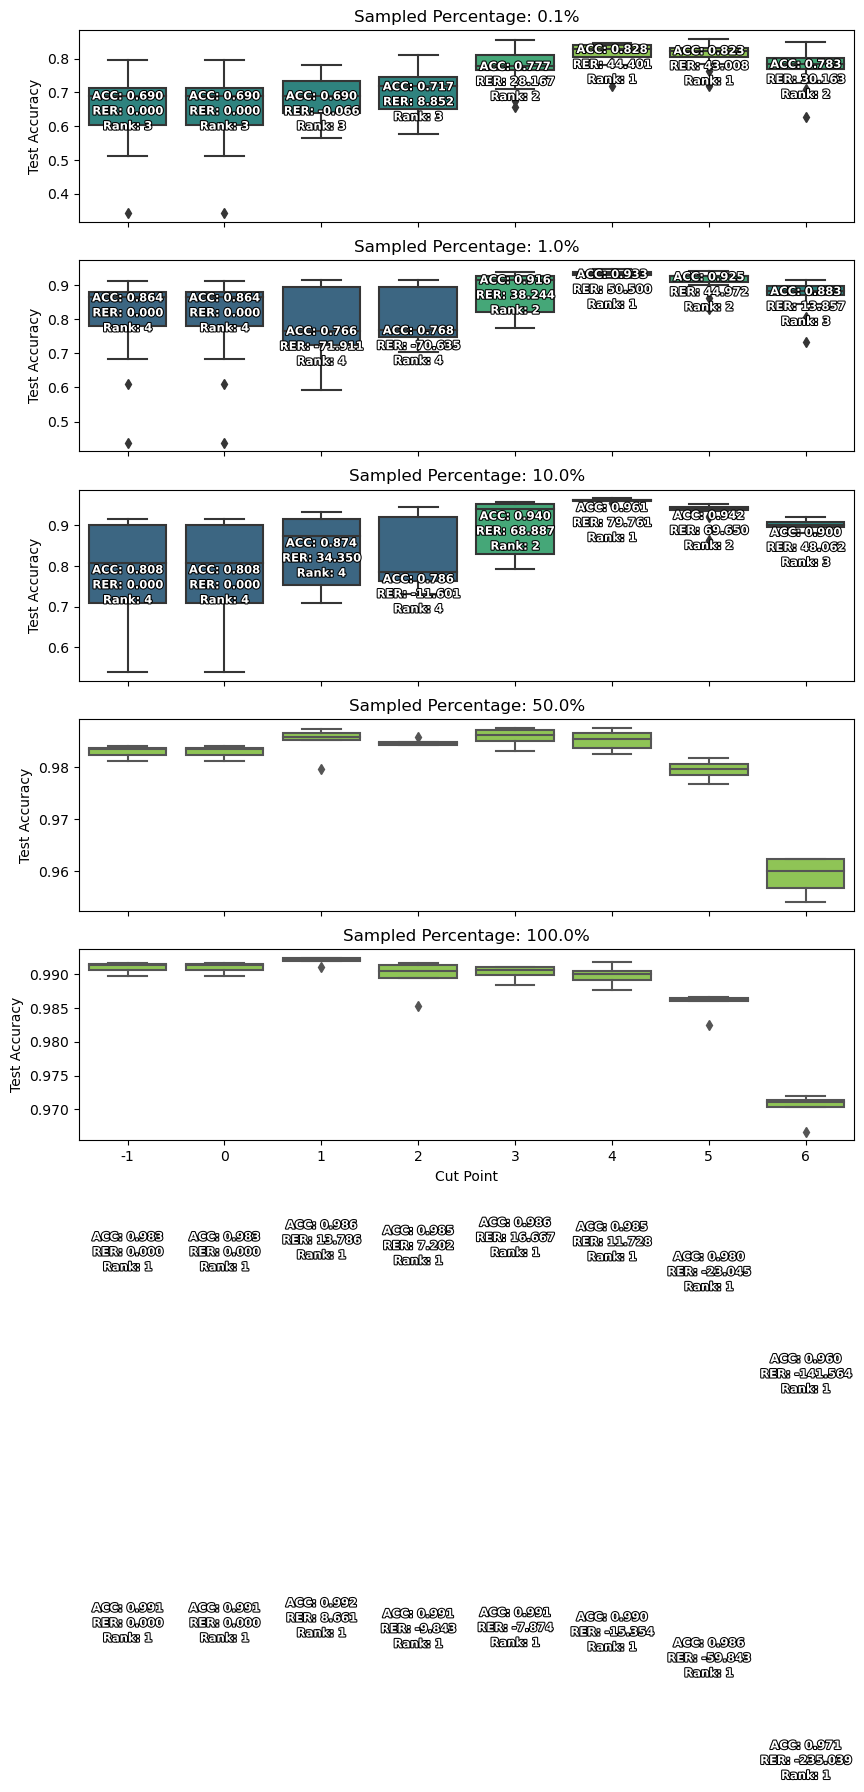

In [56]:
# run statistical tests below to get the df_rankings
_, df_rankings = get_rankings(df=df_empirical)
ranks_sorted = box_plot(df=df_empirical, rank_df=df_rankings, params=params)

<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

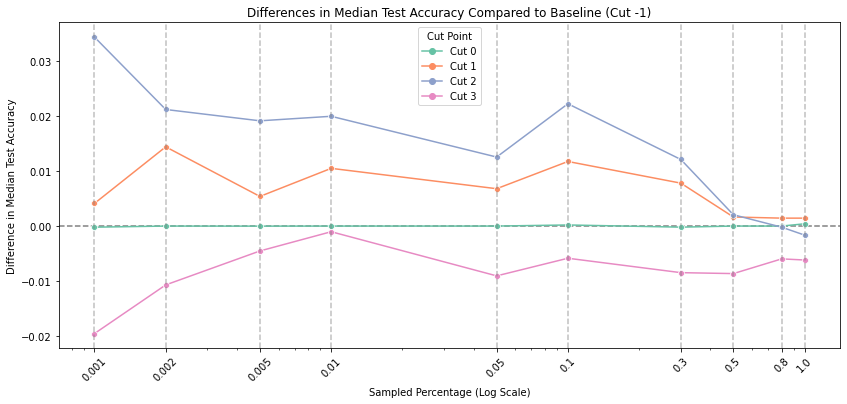

In [6]:
compare_to_baseline_line_plot(df)

<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

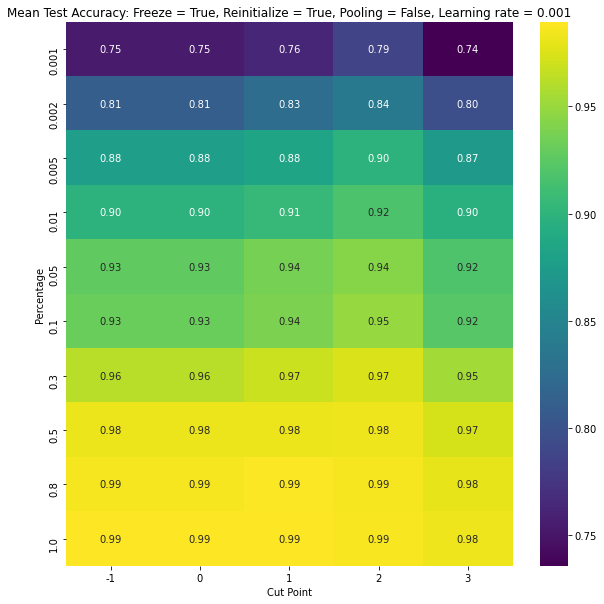

In [7]:
heatmap(df, params, figsize=(10,10))

# 2. Statistical Tests

### a. Significantly better than baseline?

In [7]:
median_baseline = df[df['Cut Point'] == -1].groupby('Percentage')['Test Accuracy'].median()
df_with_baseline = df.merge(median_baseline, on='Percentage', suffixes=('', '_baseline'))
df_with_baseline['diff_to_baseline'] = df_with_baseline['Test Accuracy'] - df_with_baseline['Test Accuracy_baseline']
df_differences = df_with_baseline[df_with_baseline['Cut Point'] != -1]

from scipy.stats import wilcoxon
import numpy as np

def perform_wilcoxon_test(data, baseline_median, cut_point):
    cut_data = data[data['Cut Point'] == cut_point]['Test Accuracy']
    baseline_data = np.full(len(cut_data), baseline_median)  # Creating an array of baseline values

    # Performing the Wilcoxon signed-rank test
    stat, p_value = wilcoxon(cut_data, baseline_data)
    return stat, p_value

# Performing the test for each cut point and sampled percentage
wilcoxon_corrected_results = []
for percentage in df_differences['Percentage'].unique():
    baseline_median = median_baseline[percentage]
    for cut_point in df_differences[df_differences['Cut Point'] != -1]['Cut Point'].unique():
        subset = df_differences[(df_differences['Percentage'] == percentage) & (df_differences['Cut Point'] == cut_point)]
        stat, p_value = perform_wilcoxon_test(subset, baseline_median, cut_point)
        wilcoxon_corrected_results.append({
            'Percentage': percentage,
            'Cut Point': cut_point,
            'statistic': stat,
            'p_value': p_value
        })

# Converting the results to a DataFrame for easier visualization
df_wilcoxon_corrected = pd.DataFrame(wilcoxon_corrected_results)


/opt/anaconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/anaconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/anaconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/anaconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if ther

In [8]:
# add a columns saying if the p-value is significant or not
df_wilcoxon_corrected['is_significant'] = df_wilcoxon_corrected['p_value'] < 0.05
df_wilcoxon_corrected

,Percentage,Cut Point,statistic,p_value,is_significant
0,0.001,0,146.5,6.720752e-01,False
1,0.001,1,120.0,2.634761e-01,False
2,0.001,2,66.0,8.068800e-03,True
3,0.001,3,67.0,8.822322e-03,True
4,0.002,0,136.0,6.891415e-01,False
5,0.002,1,74.0,1.597297e-02,True
6,0.002,2,46.0,1.027107e-03,True
7,0.002,3,96.5,7.547957e-02,False
8,0.005,0,160.0,9.578450e-01,False
9,0.005,1,94.0,6.670159e-02,False


### Ranking Cuts

In [45]:
df_wilcoxon_pairwise, _ = get_rankings(df=df_empirical)

df_wilcoxon_pairwise["statistic"] = df_wilcoxon_pairwise["statistic"].astype(int)

latex_table = df_wilcoxon_pairwise.to_latex(index=False, float_format="%.6f")
# print(latex_table)
# TODO: next, \text{p-value if significant}
# iterate over both the rows in the latex table string and the df_wilcoxon_pairwise
# if the row is significant, add the p-value to the latex table string
rows = latex_table.split("\n")[4:-3]
header = latex_table.split("\n")[:4]
footer = latex_table.split("\n")[-3:]

# iterate over the rows and the df_wilcoxon_pairwise
for i, row in enumerate(rows):
    # print(row)
    row = row.split(" & ")   
    # print(float(row[0].lstrip())*100)
    row = " & ".join([str(float(row[0].lstrip())*100)[:5]] + row[1:-1])
    if df_wilcoxon_pairwise.iloc[i]["is_significant"]:
        row = "\\rowcolor{green!20}\n" + row
    
    rows[i] = row + " \\\\"

# join the header, rows and footer, putting a "\\" at the end of each row
latex_table = "\n".join(rows)

/opt/anaconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/anaconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/anaconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/opt/anaconda/lib/python3.7/site-packages/scipy/stats/morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if ther

In [46]:
print(latex_table)

0.1 &           -1 &            0 &          0 & 1.000000 \\
0.1 &           -1 &            1 &        127 & 0.352520 \\
\rowcolor{green!20}
0.1 &           -1 &            2 &         77 & 0.020275 \\
\rowcolor{green!20}
0.1 &           -1 &            3 &          1 & 0.000000 \\
\rowcolor{green!20}
0.1 &           -1 &            4 &          0 & 0.000000 \\
\rowcolor{green!20}
0.1 &           -1 &            5 &          0 & 0.000000 \\
\rowcolor{green!20}
0.1 &           -1 &            6 &          0 & 0.000000 \\
0.1 &            0 &            1 &        127 & 0.352520 \\
\rowcolor{green!20}
0.1 &            0 &            2 &         77 & 0.020275 \\
\rowcolor{green!20}
0.1 &            0 &            3 &          1 & 0.000000 \\
\rowcolor{green!20}
0.1 &            0 &            4 &          0 & 0.000000 \\
\rowcolor{green!20}
0.1 &            0 &            5 &          0 & 0.000000 \\
\rowcolor{green!20}
0.1 &            0 &            6 &          0 & 0.000000 \\
0.1 &  

### c. Are no-reinit and reinit settings significantly different from each other?
Needs readjustments

In [ ]:
# Convert to pandas DataFrames
df_no_reinit = pd.DataFrame(results_no_reinit)
df_reinit = pd.DataFrame(results_reinit)

# Merge the dataframes on data percentage, cut point, and repeat
df_merged = pd.merge(df_no_reinit, df_reinit, on=['sampled_percentage', 'sampled_cut_point', 'repeat'], suffixes=('_no_reinit', '_reinit'))

#eliminate duplicate rows 
df_merged = df_merged.drop_duplicates(subset=['sampled_percentage', 'sampled_cut_point', 'repeat'], keep='first')

# remove cut -1 and cut 3
df_merged = df_merged[df_merged['sampled_cut_point'] != -1]
df_merged = df_merged[df_merged['sampled_cut_point'] != 3]

# Group by percentage and cut point
grouped = df_merged.groupby(['sampled_percentage', 'sampled_cut_point'])

# Perform the Wilcoxon signed-rank test for each group
def perform_wilcoxon_test(group):
    test_acc_no_reinit = group['test_acc_no_reinit'].to_numpy()
    test_acc_reinit = group['test_acc_reinit'].to_numpy()

    stat, p_value = wilcoxon(test_acc_no_reinit, test_acc_reinit)
    return pd.Series({'statistic': stat, 'p_value': p_value})

# Apply the test to each group and reset index
wilcoxon_results = grouped.apply(perform_wilcoxon_test).reset_index()

# Add a column indicating significance
wilcoxon_results['is_significant'] = wilcoxon_results['p_value'] < 0.05

# Display the final results
wilcoxon_results